# Assignment 4

The objective of this assignment is to introduce you to federated learning, with a particular focus on the challenges posed by data heterogeneity. Specifically, you will explore well-known approaches for addressing statistical heterogeneity, approaching the problem from multiple angles.

You have been provided with a manual that includes detailed descriptions of each task. Follow the instructions in the manual carefully, and add your answers and implementations directly in this notebook.

Note: In this assignment, we concentrate on one common type of statistical heterogeneity: label skew. While feature skew is another significant aspect of heterogeneity, it will not be the focus of this assignment.

In [1]:
import os
import torch
from torchvision import datasets, transforms
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from collections import defaultdict
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Subset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Calculate sizes for training and testing datasets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Define fixed indices for train and test splits
train_indices = list(range(train_size))
test_indices = list(range(train_size, len(dataset)))

# Create Subsets based on these indices
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_images = dataset.data[train_dataset.indices].numpy()
train_labels = dataset.targets[train_dataset.indices].numpy()
test_images = dataset.data[test_dataset.indices].numpy()
test_labels = dataset.targets[test_dataset.indices].numpy()


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 10.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 326kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.55MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.00MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
def partition_data(train_data, train_targets, test_data, test_targets, num_clients, dirichlet_alpha=0.5, batch_size=32):
    num_classes = len(np.unique(train_targets))
    client_data_indices = defaultdict(list)
    client_test_indices = defaultdict(list)

    # Partition Train Data and Capture Proportions
    client_proportions = []
    for c in range(num_classes):
        class_indices = np.where(train_targets == c)[0]
        proportions = np.random.dirichlet([dirichlet_alpha] * num_clients)
        client_proportions.append(proportions)

        # Calculate split sizes and assign indices to each client
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_data_indices[i].extend(indices)

    # Partition Test Data Using the Same Proportions as Train Data
    for c, proportions in enumerate(client_proportions):
        class_indices = np.where(test_targets == c)[0]
        split_sizes = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        client_indices_split = np.split(class_indices, split_sizes)

        for i, indices in enumerate(client_indices_split):
            client_test_indices[i].extend(indices)

    # Create Federated Loaders
    federated_train_loaders, federated_test_loaders = [], []
    for i in range(num_clients):
        client_train_data = torch.tensor(train_data[client_data_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_train_targets = torch.tensor(train_targets[client_data_indices[i]], dtype=torch.long)
        train_loader = DataLoader(TensorDataset(client_train_data, client_train_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_train_loaders.append(train_loader)

        client_test_data = torch.tensor(test_data[client_test_indices[i]], dtype=torch.float32).unsqueeze(1)
        client_test_targets = torch.tensor(test_targets[client_test_indices[i]], dtype=torch.long)
        test_loader = DataLoader(TensorDataset(client_test_data, client_test_targets), batch_size=batch_size, shuffle=False, drop_last=False)
        federated_test_loaders.append(test_loader)

    # Create Centralized Loader by combining data from federated loaders
    centralized_data, centralized_targets = [], []
    for train_loader in federated_train_loaders:
        for images, targets in train_loader:
            centralized_data.append(images)
            centralized_targets.append(targets)

    centralized_data = torch.cat(centralized_data)
    centralized_targets = torch.cat(centralized_targets)
    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=False, drop_last=False)

    centralized_test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_targets, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader


In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 500)
        self.fc2 = nn.Linear(500,10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Task 2: FedAvg
Implement the fedavg_training function to perform Federated Averaging (FedAvg) over multiple communication rounds. Each round, collect updates from clients by training locally on their data and average these updates to form a new global model.

Additionally, implement the local_train function to handle client-side training. You are not restricted to using full-batch gradient descent; feel free to use mini-batch gradient descent instead. Make sure your implementation aligns with the provided code to plot the accuracies, as you should not modify that code.

In [10]:
def evaluate_model(global_model, test_loaders):
    global_model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(device)

    client_accuracies = []
    total_correct, total_samples = 0, 0

    with torch.no_grad():
        for client_id, test_loader in enumerate(test_loaders):
            client_correct, client_total = 0, 0
            print(f"\nEvaluating Client {client_id}")

            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = global_model(images)
                _, predicted = torch.max(outputs, 1)

                client_correct += (predicted == labels).sum().item()
                client_total += labels.size(0)

            client_accuracy = (client_correct / client_total) * 100
            client_accuracies.append(client_accuracy)

            print(f"Client {client_id} Accuracy: {client_accuracy:.2f}%")

            total_correct += client_correct
            total_samples += client_total

    total_accuracy = (total_correct / total_samples) * 100
    print(f"Total Accuracy: {total_accuracy:.2f}%")
    return client_accuracies, total_accuracy


In [11]:
from copy import deepcopy

# Server-side Federated Averaging
def fedavg_training(global_model, train_loaders, num_clients, rounds, epochs, lr, test_loaders):
    round_avg_updates = []
    round_accuracies = []

    for r in tqdm(range(rounds), desc="Communication Rounds", leave=True):
        client_updates = []

        # Distribute model and collect client updates
        for i in tqdm(range(num_clients), desc=f"Clients Training (Round {r+1})", leave=False):
            update = local_train(global_model, train_loaders[i], epochs, lr)
            client_updates.append(update)

        # Average updates
        avg_update = {name: sum(client_update[name] for client_update in client_updates) / num_clients
                      for name in global_model.state_dict().keys()}

        # Apply averaged updates to global model
        for name, param in global_model.state_dict().items():
            param.add_(avg_update[name])  # Update the global model in-place

        round_avg_updates.append(avg_update)

        # Evaluate the global model
        global_model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for test_loader in test_loaders:
                for data, labels in tqdm(test_loader, desc=f"Evaluating (Round {r+1})", leave=False):
                    data, labels = data.to(next(global_model.parameters()).device), labels.to(next(global_model.parameters()).device)
                    outputs = global_model(data)
                    _, predicted = outputs.max(1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

        accuracy = correct / total
        round_accuracies.append(accuracy)
        tqdm.write(f"Round {r+1} Accuracy: {accuracy:.4f}")

    return round_avg_updates, round_accuracies


# Client-side local training
def local_train(model, train_loader, epochs, lr):
    # Copy the global model to avoid modifying it directly
    local_model = deepcopy(model)
    local_model.load_state_dict(model.state_dict())
    local_model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(local_model.parameters(), lr=lr)

    # Train the local model
    local_model.train()
    for epoch in tqdm(range(epochs), desc="Local Training", leave=False):
        for data, labels in train_loader:
            data, labels = data.to(next(local_model.parameters()).device), labels.to(next(local_model.parameters()).device)
            optimizer.zero_grad()
            outputs = local_model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Compute updates (difference between global and local weights)
    overall_update = {name: param.data - model.state_dict()[name]
                      for name, param in local_model.state_dict().items()}

    return overall_update

In the following code you may change the learning rate or the batch size

In [12]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
dirichlet_alphas = [2, 0.5, 0.1]

def run_fedavg(alpha):
    train_loaders, test_loaders,_,_ = partition_data(train_images / 255, train_labels, test_images / 255, test_labels, num_clients, alpha, batch_size)
    global_model_fedavg = SimpleCNN()
    _, round_accuracies = fedavg_training(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)
    return round_accuracies

accuracies_per_alpha = []

for alpha in dirichlet_alphas:
    round_accuracies = run_fedavg(alpha)
    accuracies_per_alpha.append(round_accuracies)


Clients Training (Round 1):   0%|          | 0/5 [00:00<?, ?it/s]

Local Training:   0%|          | 0/20 [00:00<?, ?it/s]

Local Training:   5%|▌         | 1/20 [00:01<00:37,  1.95s/it]

Local Training:  10%|█         | 2/20 [00:03<00:32,  1.82s/it]

Local Training:  15%|█▌        | 3/20 [00:05<00:30,  1.78s/it]

Local Training:  20%|██        | 4/20 [00:07<00:28,  1.78s/it]

Local Training:  25%|██▌       | 5/20 [00:09<00:30,  2.03s/it]

Local Training:  30%|███       | 6/20 [00:11<00:27,  1.93s/it]

Local Training:  35%|███▌      | 7/20 [00:13<00:24,  1.87s/it]

Local Training:  40%|████      | 8/20 [00:14<00:21,  1.82s/it]

Local Training:  45%|████▌     | 9/20 [00:16<00:19,  1.79s/it]

Local Training:  50%|█████     | 10/20 [00:18<00:17,  1.77s/it]

Local Training:  55%|█████▌    | 11/20 [00:20<00:16,  1.80s/it]

Local Training:  60%|██████    | 12/20 [00:22<00:15,  1.96s/it]

Local Training:  65%|██████▌   | 13/20 [00:24<00:13,  1.89s/it]

Local Training:  70%|███████   | 14/20 [0

Round 1 Accuracy: 0.1741



Clients Training (Round 2):   0%|          | 0/5 [00:00<?, ?it/s]

Local Training:   0%|          | 0/20 [00:00<?, ?it/s]

Local Training:   5%|▌         | 1/20 [00:02<00:43,  2.30s/it]

Local Training:  10%|█         | 2/20 [00:04<00:35,  1.96s/it]

Local Training:  15%|█▌        | 3/20 [00:05<00:31,  1.85s/it]

Local Training:  20%|██        | 4/20 [00:07<00:28,  1.78s/it]

Local Training:  25%|██▌       | 5/20 [00:09<00:26,  1.76s/it]

Local Training:  30%|███       | 6/20 [00:10<00:24,  1.74s/it]

Local Training:  35%|███▌      | 7/20 [00:12<00:23,  1.80s/it]

Local Training:  40%|████      | 8/20 [00:14<00:23,  1.93s/it]

Local Training:  45%|████▌     | 9/20 [00:16<00:20,  1.85s/it]

Local Training:  50%|█████     | 10/20 [00:18<00:18,  1.81s/it]

Local Training:  55%|█████▌    | 11/20 [00:20<00:16,  1.78s/it]

Local Training:  60%|██████    | 12/20 [00:21<00:14,  1.76s/it]

Local Training:  65%|██████▌   | 13/20 [00:23<00:12,  1.73s/it]

Local Training:  70%|███████   | 14/20 [

Round 2 Accuracy: 0.4260



Clients Training (Round 3):   0%|          | 0/5 [00:00<?, ?it/s]

Local Training:   0%|          | 0/20 [00:00<?, ?it/s]

Local Training:   5%|▌         | 1/20 [00:01<00:31,  1.68s/it]

Local Training:  10%|█         | 2/20 [00:03<00:30,  1.67s/it]

Local Training:  15%|█▌        | 3/20 [00:04<00:28,  1.65s/it]

Local Training:  20%|██        | 4/20 [00:06<00:26,  1.64s/it]

Local Training:  25%|██▌       | 5/20 [00:08<00:27,  1.85s/it]

Local Training:  30%|███       | 6/20 [00:10<00:25,  1.84s/it]

Local Training:  35%|███▌      | 7/20 [00:12<00:24,  1.85s/it]

Local Training:  40%|████      | 8/20 [00:14<00:21,  1.81s/it]

Local Training:  45%|████▌     | 9/20 [00:15<00:19,  1.75s/it]

Local Training:  50%|█████     | 10/20 [00:17<00:17,  1.72s/it]

Local Training:  55%|█████▌    | 11/20 [00:19<00:15,  1.71s/it]

Local Training:  60%|██████    | 12/20 [00:21<00:14,  1.86s/it]

Local Training:  65%|██████▌   | 13/20 [00:23<00:12,  1.85s/it]

Local Training:  70%|███████   | 14/20 [

Round 3 Accuracy: 0.6396


Clients Training (Round 1):   0%|          | 0/5 [00:00<?, ?it/s]

Local Training:   0%|          | 0/20 [00:00<?, ?it/s]

Local Training:   5%|▌         | 1/20 [00:03<01:00,  3.17s/it]

Local Training:  10%|█         | 2/20 [00:06<00:57,  3.17s/it]

Local Training:  15%|█▌        | 3/20 [00:09<00:51,  3.02s/it]

Local Training:  20%|██        | 4/20 [00:12<00:47,  2.95s/it]

Local Training:  25%|██▌       | 5/20 [00:15<00:44,  2.99s/it]

Local Training:  30%|███       | 6/20 [00:18<00:43,  3.13s/it]

Local Training:  35%|███▌      | 7/20 [00:21<00:39,  3.06s/it]

Local Training:  40%|████      | 8/20 [00:24<00:35,  2.99s/it]

Local Training:  45%|████▌     | 9/20 [00:27<00:32,  2.95s/it]

Local Training:  50%|█████     | 10/20 [00:30<00:31,  3.12s/it]

Local Training:  55%|█████▌    | 11/20 [00:33<00:27,  3.04s/it]

Local Training:  60%|██████    | 12/20 [00:36<00:23,  2.99s/it]

Local Training:  65%|██████▌   | 13/20 [00:39<00:20,  2.98s/it]

Local Training:  70%|███████   | 14/20 [0

Round 1 Accuracy: 0.1059



Clients Training (Round 2):   0%|          | 0/5 [00:00<?, ?it/s]

Local Training:   0%|          | 0/20 [00:00<?, ?it/s]

Local Training:   5%|▌         | 1/20 [00:03<01:11,  3.74s/it]

Local Training:  10%|█         | 2/20 [00:06<00:58,  3.27s/it]

Local Training:  15%|█▌        | 3/20 [00:09<00:52,  3.11s/it]

Local Training:  20%|██        | 4/20 [00:12<00:48,  3.04s/it]

Local Training:  25%|██▌       | 5/20 [00:16<00:49,  3.28s/it]

Local Training:  30%|███       | 6/20 [00:19<00:44,  3.18s/it]

Local Training:  35%|███▌      | 7/20 [00:22<00:40,  3.10s/it]

Local Training:  40%|████      | 8/20 [00:25<00:36,  3.05s/it]

Local Training:  45%|████▌     | 9/20 [00:28<00:35,  3.25s/it]

Local Training:  50%|█████     | 10/20 [00:31<00:31,  3.15s/it]

Local Training:  55%|█████▌    | 11/20 [00:34<00:27,  3.09s/it]

Local Training:  60%|██████    | 12/20 [00:37<00:24,  3.06s/it]

Local Training:  65%|██████▌   | 13/20 [00:41<00:22,  3.25s/it]

Local Training:  70%|███████   | 14/20 [

Round 2 Accuracy: 0.3080



Clients Training (Round 3):   0%|          | 0/5 [00:00<?, ?it/s]

Local Training:   0%|          | 0/20 [00:00<?, ?it/s]

Local Training:   5%|▌         | 1/20 [00:03<01:07,  3.55s/it]

Local Training:  10%|█         | 2/20 [00:06<00:58,  3.24s/it]

Local Training:  15%|█▌        | 3/20 [00:09<00:52,  3.07s/it]

Local Training:  20%|██        | 4/20 [00:12<00:47,  3.00s/it]

Local Training:  25%|██▌       | 5/20 [00:15<00:47,  3.17s/it]

Local Training:  30%|███       | 6/20 [00:18<00:44,  3.15s/it]

Local Training:  35%|███▌      | 7/20 [00:21<00:39,  3.05s/it]

Local Training:  40%|████      | 8/20 [00:24<00:36,  3.00s/it]

Local Training:  45%|████▌     | 9/20 [00:27<00:34,  3.11s/it]

Local Training:  50%|█████     | 10/20 [00:31<00:31,  3.13s/it]

Local Training:  55%|█████▌    | 11/20 [00:34<00:27,  3.05s/it]

Local Training:  60%|██████    | 12/20 [00:36<00:24,  3.01s/it]

Local Training:  65%|██████▌   | 13/20 [00:40<00:21,  3.09s/it]

Local Training:  70%|███████   | 14/20 [

Round 3 Accuracy: 0.5563


Clients Training (Round 1):   0%|          | 0/5 [00:00<?, ?it/s]

Local Training:   0%|          | 0/20 [00:00<?, ?it/s]

Local Training:   5%|▌         | 1/20 [00:06<01:54,  6.02s/it]

Local Training:  10%|█         | 2/20 [00:11<01:40,  5.56s/it]

Local Training:  15%|█▌        | 3/20 [00:17<01:38,  5.80s/it]

Local Training:  20%|██        | 4/20 [00:22<01:29,  5.57s/it]

Local Training:  25%|██▌       | 5/20 [00:28<01:23,  5.57s/it]

Local Training:  30%|███       | 6/20 [00:33<01:18,  5.61s/it]

Local Training:  35%|███▌      | 7/20 [00:39<01:11,  5.50s/it]

Local Training:  40%|████      | 8/20 [00:45<01:07,  5.64s/it]

Local Training:  45%|████▌     | 9/20 [00:50<01:00,  5.53s/it]

Local Training:  50%|█████     | 10/20 [00:56<00:56,  5.67s/it]

Local Training:  55%|█████▌    | 11/20 [01:01<00:49,  5.54s/it]

Local Training:  60%|██████    | 12/20 [01:07<00:45,  5.68s/it]

Local Training:  65%|██████▌   | 13/20 [01:12<00:38,  5.56s/it]

Local Training:  70%|███████   | 14/20 [0

Round 1 Accuracy: 0.0989



Clients Training (Round 2):   0%|          | 0/5 [00:00<?, ?it/s]

Local Training:   0%|          | 0/20 [00:00<?, ?it/s]

Local Training:   5%|▌         | 1/20 [00:05<01:40,  5.29s/it]

Local Training:  10%|█         | 2/20 [00:11<01:41,  5.62s/it]

Local Training:  15%|█▌        | 3/20 [00:16<01:33,  5.50s/it]

Local Training:  20%|██        | 4/20 [00:21<01:27,  5.45s/it]

Local Training:  25%|██▌       | 5/20 [00:27<01:24,  5.62s/it]

Local Training:  30%|███       | 6/20 [00:33<01:17,  5.53s/it]

Local Training:  35%|███▌      | 7/20 [00:39<01:13,  5.67s/it]

Local Training:  40%|████      | 8/20 [00:44<01:06,  5.55s/it]

Local Training:  45%|████▌     | 9/20 [00:50<01:02,  5.69s/it]

Local Training:  50%|█████     | 10/20 [00:55<00:55,  5.56s/it]

Local Training:  55%|█████▌    | 11/20 [01:01<00:51,  5.72s/it]

Local Training:  60%|██████    | 12/20 [01:07<00:44,  5.59s/it]

Local Training:  65%|██████▌   | 13/20 [01:12<00:39,  5.69s/it]

Local Training:  70%|███████   | 14/20 [

Round 2 Accuracy: 0.1754



Clients Training (Round 3):   0%|          | 0/5 [00:00<?, ?it/s]

Local Training:   0%|          | 0/20 [00:00<?, ?it/s]

Local Training:   5%|▌         | 1/20 [00:05<01:37,  5.11s/it]

Local Training:  10%|█         | 2/20 [00:10<01:39,  5.54s/it]

Local Training:  15%|█▌        | 3/20 [00:15<01:30,  5.31s/it]

Local Training:  20%|██        | 4/20 [00:21<01:27,  5.47s/it]

Local Training:  25%|██▌       | 5/20 [00:26<01:19,  5.32s/it]

Local Training:  30%|███       | 6/20 [00:32<01:16,  5.45s/it]

Local Training:  35%|███▌      | 7/20 [00:37<01:09,  5.32s/it]

Local Training:  40%|████      | 8/20 [00:42<01:02,  5.22s/it]

Local Training:  45%|████▌     | 9/20 [00:48<00:58,  5.36s/it]

Local Training:  50%|█████     | 10/20 [00:53<00:52,  5.24s/it]

Local Training:  55%|█████▌    | 11/20 [00:58<00:48,  5.37s/it]

Local Training:  60%|██████    | 12/20 [01:03<00:41,  5.24s/it]

Local Training:  65%|██████▌   | 13/20 [01:09<00:37,  5.39s/it]

Local Training:  70%|███████   | 14/20 [

Round 3 Accuracy: 0.2353


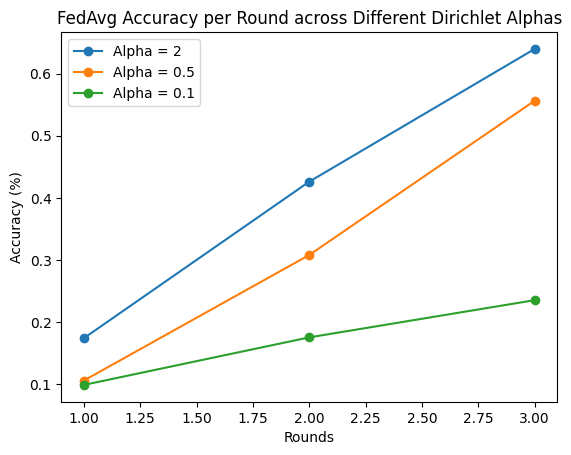

In [13]:
# Plotting accuracy per round for each alpha value
plt.figure()
for idx, alpha in enumerate(dirichlet_alphas):
    plt.plot(range(1, rounds + 1), accuracies_per_alpha[idx], marker='o', label=f'Alpha = {alpha}')

plt.xlabel('Rounds')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('FedAvg Accuracy per Round across Different Dirichlet Alphas')
plt.show()

# With one class per client

In [25]:
from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np

def partition_data_new(train_images, train_labels, test_images, test_labels, num_clients, dirichlet_alpha, batch_size):
    num_classes = len(np.unique(train_labels))
    client_train_data = defaultdict(list)
    client_test_data = defaultdict(list)

    # Ensure that each client gets one class
    for c in range(num_classes):
        class_indices = np.where(train_labels == c)[0]

        # Assign each class to a different client
        client_train_data[c].extend(class_indices)

        # Similarly, assign test data to the corresponding client
        class_test_indices = np.where(test_labels == c)[0]
        client_test_data[c].extend(class_test_indices)

    # Create Federated Loaders for Clients
    federated_train_loaders, federated_test_loaders = [], []

    # Loop through each client
    for i in range(num_clients):
        if i < num_classes:  # Only assign data to clients for which there is class data
            # Extract data for the current client based on the class
            train_data = torch.tensor(train_images[client_train_data[i]], dtype=torch.float32).unsqueeze(1)
            train_targets = torch.tensor(train_labels[client_train_data[i]], dtype=torch.long)

            # Create DataLoader for the current client
            train_loader = DataLoader(TensorDataset(train_data, train_targets), batch_size=batch_size, shuffle=True)
            federated_train_loaders.append(train_loader)

            # Extract test data for the current client based on the class
            test_data = torch.tensor(test_images[client_test_data[i]], dtype=torch.float32).unsqueeze(1)
            test_targets = torch.tensor(test_labels[client_test_data[i]], dtype=torch.long)

            # Create DataLoader for test data of the current client
            test_loader = DataLoader(TensorDataset(test_data, test_targets), batch_size=batch_size, shuffle=False)
            federated_test_loaders.append(test_loader)

    # Create Centralized Loaders by combining data from federated loaders
    centralized_data, centralized_targets = [], []
    for train_loader in federated_train_loaders:
        for images, targets in train_loader:
            centralized_data.append(images)
            centralized_targets.append(targets)

    centralized_data = torch.cat(centralized_data)
    centralized_targets = torch.cat(centralized_targets)
    train_centralized_loader = DataLoader(TensorDataset(centralized_data, centralized_targets), batch_size=batch_size, shuffle=True)

    # Centralized test loader
    centralized_test_data = torch.tensor(test_images, dtype=torch.float32).unsqueeze(1)
    centralized_test_targets = torch.tensor(test_labels, dtype=torch.long)
    test_centralized_loader = DataLoader(TensorDataset(centralized_test_data, centralized_test_targets), batch_size=batch_size, shuffle=False)

    return federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader


In [26]:
num_clients = 10
dirichlet_alpha = 0.001
batch_size = 1

# Partition data and create loaders
federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader = partition_data_new(
    train_images / 255.0, train_labels, test_images / 255.0, test_labels, num_clients, dirichlet_alpha, batch_size
)
total_train_pts =0
total_test_pts =0
#print number of data points for each client
for i in range(num_clients):
    print(f"Client {i} Train Data: {len(federated_train_loaders[i].dataset)} Test Data: {len(federated_test_loaders[i].dataset)}")
    total_train_pts += len(federated_train_loaders[i].dataset)
    total_test_pts += len(federated_test_loaders[i].dataset)

print(f"Total Train Data: {total_train_pts} Test Data: {total_test_pts}")

#total number of data points in centralized loader
print(f"Centralized Train Data: {len(train_centralized_loader.dataset)} Test Data: {len(test_centralized_loader.dataset)}")

#print number of classes for each client
for i in range(num_clients):
    print(f"Client {i} Classes: {np.unique(federated_train_loaders[i].dataset.tensors[1].numpy())}")


Client 0 Train Data: 4729 Test Data: 1194
Client 1 Train Data: 5470 Test Data: 1272
Client 2 Train Data: 4762 Test Data: 1196
Client 3 Train Data: 4889 Test Data: 1242
Client 4 Train Data: 4655 Test Data: 1187
Client 5 Train Data: 4324 Test Data: 1097
Client 6 Train Data: 4748 Test Data: 1170
Client 7 Train Data: 4968 Test Data: 1297
Client 8 Train Data: 4653 Test Data: 1198
Client 9 Train Data: 4802 Test Data: 1147
Total Train Data: 48000 Test Data: 12000
Centralized Train Data: 48000 Test Data: 12000
Client 0 Classes: [0]
Client 1 Classes: [1]
Client 2 Classes: [2]
Client 3 Classes: [3]
Client 4 Classes: [4]
Client 5 Classes: [5]
Client 6 Classes: [6]
Client 7 Classes: [7]
Client 8 Classes: [8]
Client 9 Classes: [9]


In [28]:
# Parameters
num_clients = 5
batch_size = 128
rounds = 3
epochs = 20
lr = 0.001
dirichlet_alphas = [2, 0.5, 0.1]

train_loaders, test_loaders,_,_ = federated_train_loaders, federated_test_loaders, train_centralized_loader, test_centralized_loader
global_model_fedavg = SimpleCNN()
_, round_accuracies = fedavg_training(global_model_fedavg, train_loaders, num_clients, rounds=rounds, epochs=epochs, lr=lr, test_loaders=test_loaders)

Clients Training (Round 1):   0%|          | 0/5 [00:00<?, ?it/s]

Local Training:   0%|          | 0/20 [00:00<?, ?it/s]

Local Training:   5%|▌         | 1/20 [00:11<03:41, 11.63s/it]

Local Training:  10%|█         | 2/20 [00:23<03:31, 11.77s/it]

Local Training:  15%|█▌        | 3/20 [00:35<03:22, 11.90s/it]

Local Training:  20%|██        | 4/20 [00:48<03:14, 12.14s/it]

Local Training:  25%|██▌       | 5/20 [00:59<03:00, 12.06s/it]

Local Training:  30%|███       | 6/20 [01:11<02:47, 11.95s/it]

Local Training:  35%|███▌      | 7/20 [01:23<02:35, 11.94s/it]

Local Training:  40%|████      | 8/20 [01:36<02:24, 12.08s/it]

Local Training:  45%|████▌     | 9/20 [01:48<02:12, 12.09s/it]

Local Training:  50%|█████     | 10/20 [02:00<02:01, 12.11s/it]

Local Training:  55%|█████▌    | 11/20 [02:12<01:48, 12.11s/it]

Local Training:  60%|██████    | 12/20 [02:24<01:36, 12.12s/it]

Local Training:  65%|██████▌   | 13/20 [02:36<01:25, 12.17s/it]

Local Training:  70%|███████   | 14/20 [0

Round 1 Accuracy: 0.1446



Clients Training (Round 2):   0%|          | 0/5 [00:00<?, ?it/s]

Local Training:   0%|          | 0/20 [00:00<?, ?it/s]

Local Training:   5%|▌         | 1/20 [00:12<03:53, 12.31s/it]

Local Training:  10%|█         | 2/20 [00:24<03:39, 12.21s/it]

Local Training:  15%|█▌        | 3/20 [00:36<03:26, 12.13s/it]

Local Training:  20%|██        | 4/20 [00:48<03:12, 12.05s/it]

Local Training:  25%|██▌       | 5/20 [01:00<02:59, 11.98s/it]

Local Training:  30%|███       | 6/20 [01:12<02:46, 11.91s/it]

Local Training:  35%|███▌      | 7/20 [01:24<02:35, 11.93s/it]

Local Training:  40%|████      | 8/20 [01:36<02:23, 11.99s/it]

Local Training:  45%|████▌     | 9/20 [01:48<02:11, 12.00s/it]

Local Training:  50%|█████     | 10/20 [02:00<02:00, 12.01s/it]

Local Training:  55%|█████▌    | 11/20 [02:12<01:48, 12.02s/it]

Local Training:  60%|██████    | 12/20 [02:24<01:36, 12.06s/it]

Local Training:  65%|██████▌   | 13/20 [02:36<01:24, 12.04s/it]

Local Training:  70%|███████   | 14/20 [

Round 2 Accuracy: 0.1218



Clients Training (Round 3):   0%|          | 0/5 [00:00<?, ?it/s]

Local Training:   0%|          | 0/20 [00:00<?, ?it/s]

Local Training:   5%|▌         | 1/20 [00:11<03:36, 11.39s/it]

Local Training:  10%|█         | 2/20 [00:22<03:24, 11.34s/it]

Local Training:  15%|█▌        | 3/20 [00:34<03:12, 11.35s/it]

Local Training:  20%|██        | 4/20 [00:45<03:02, 11.41s/it]

Local Training:  25%|██▌       | 5/20 [00:57<02:51, 11.42s/it]

Local Training:  30%|███       | 6/20 [01:08<02:40, 11.45s/it]

Local Training:  35%|███▌      | 7/20 [01:19<02:28, 11.41s/it]

Local Training:  40%|████      | 8/20 [01:31<02:16, 11.34s/it]

Local Training:  45%|████▌     | 9/20 [01:42<02:03, 11.24s/it]

Local Training:  50%|█████     | 10/20 [01:53<01:51, 11.19s/it]

Local Training:  55%|█████▌    | 11/20 [02:04<01:42, 11.39s/it]

Local Training:  60%|██████    | 12/20 [02:16<01:32, 11.58s/it]

Local Training:  65%|██████▌   | 13/20 [02:28<01:20, 11.52s/it]

Local Training:  70%|███████   | 14/20 [

Round 3 Accuracy: 0.1144
